## **Multi-Dimensional Kalman Filter**

The data for this task was collected from two different sensors: accelerometer and GPS at the same time interval. 

- The accelerometer provides linear accelerations in x, y & z, these values were integrated once to obtain velocities and integrated twice to obtain position.

- The GPS provides longitude (in x-direction), latitude (in y-direction) & velocity; however, the velocity values were disregarded due to their small values. (app measures in Km/s)

The main equations for the motion model and sensor measurements are represented by:

- $ x_{t+1} = \phi_t x_t + w_t $ 
- $ z_t = H_t x_t + v_t $

The state vector $x_t$ was selected to contain [$x$, $y$, $\dot{x}$, $\dot{y}$] 

The measurement vector $z_t$ was selected to contain [$x_1$, $y_1$, $\dot{x_1}$, $\dot{y_1}$, $x_2$, $y_2$] 

--> The index[1] represents the accelerometer sensor data 

--> The index[2] represents the GPS data

**Note:** 

The accelerometer data were mapped to the GPS values by setting the initial conditions to the accelerometer data to be as that of the GPS. Hence, the remapping of the rest of the data is done accordingly. 

{i.e, Transformed the accelerometer frame to the GPS frame}


In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Reading data from both sensors (Accelerometer & GPS)
data = np.loadtxt('sohaila_data.csv',delimiter=',',skiprows=2, usecols=(0,1,2,3,4,5))

# Time vector
time = data[:,0]
# Accelerometer data
acc = data[:,1:4]
# GPS data
gps = data[:,4:6]

# Vectors X & Y for GPS
X_gps = gps[:,1]  # longitude
Y_gps = gps[:,0]  # latitude

# Vectors X & Y for acceleration
X_acc = acc[:,0]
Y_acc = acc[:,1]

# Obtaining velocity from acceleration
X_vel = np.zeros(len(X_acc))  
Y_vel = np.zeros(len(Y_acc))
# integration
for i in range(len(X_acc)-1):
  X_vel[i+1] = X_acc[i]*(time[i+1] - time[i]) + X_vel[i]
  Y_vel[i+1] = Y_acc[i]*(time[i+1] - time[i]) + Y_vel[i]

# Obtaining position from velocity
X_pos = np.zeros(len(X_acc))
X_pos[0] = X_gps[1]  # initial condition
Y_pos = np.zeros(len(Y_acc))
Y_pos[0] = Y_gps[1]  # initial condition
# integration
for i in range(len(X_acc)-1):
  X_pos[i+1] = X_vel[i]*(time[i+1] - time[i]) + X_pos[i]
  Y_pos[i+1] = Y_vel[i]*(time[i+1] - time[i]) + Y_pos[i]

There are some parameters initialized before going through the Kalman Filter algorithm:

1- The state transition matrix $\phi_t$ is a 4x4 matrix designed as follows:
$\phi_t = \begin{pmatrix} 
1 & 0 & Δt & 0 \\
0 & 1 & 0 & Δt \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \end{pmatrix}$

2- The transition matrix $H$ that maps between the measuremnt and state vector is a 6x4 matrix designed as follows:
$H =\begin{pmatrix} 
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \end{pmatrix}$

3- The uncertainty covariance matrix $P$ is initialized by a diagonal matrix with high values, since we do not know much about the model initial estimate.

It is defined as follows: 
$P= \begin{pmatrix} 
500 & 0 & 0 & 0 \\
0 & 500 & 0 & 0 \\
0 & 0 & 500 & 0 \\
0 & 0 & 0 & 500 \end{pmatrix}$

4- The error covariance matrix of the states of the motion model is defined as: 
$Q_k= \begin{pmatrix} 
0.1 & 0 & 0 & 0 \\
0 & 0.1 & 0 & 0 \\
0 & 0 & 0.1 & 0 \\
0 & 0 & 0 & 0.1 \end{pmatrix}$

5- The error covariance matrix of the sensor measurements is defined as: 
$R_k= \begin{pmatrix} 
2 & 0 & 0 & 0 & 0 & 0 \\
0 & 2 & 0 & 0 & 0 & 0 \\
0 & 0 & 2 & 0 & 0 & 0 \\
0 & 0 & 0 & 2 & 0 & 0 \\
0 & 0 & 0 & 0 & 25 & 0 \\
0 & 0 & 0 & 0 & 0 & 25 \end{pmatrix}$


The values for the $Q_k$ and $R_K$ were selected relative to each other, in which the values of $Q_k$ were choosen to imply small variance and a more trustworhty motion model. However, the $R_K$ values were selected to be higher than the $Q_k$, as it is intended to depend less on the sensor data. Moreover, the variance for the GPS values was assigned to be higher than that of the accelerometer, as we depend more on the accelerometer data rather than the GPS.

In [7]:
# Initializing parameters
dt = time[1] - time[0]

# Covariance of sensor readings
R = np.array([[2,0,0,0,0,0],
              [0,2,0,0,0,0],
              [0,0,2,0,0,0],
              [0,0,0,2,0,0],
              [0,0,0,0,25,0],
              [0,0,0,0,0,25]])

# Covariance of motion model
Q = np.array([[0.1,0,0,0],
              [0,0.1,0,0],
              [0,0,0.1,0],
              [0,0,0,0.1]])

# Uncertainty covariance matrix
P = np.array([[500,0,0,0],
              [0,500,0,0],
              [0,0,500,0],
              [0,0,0,500]])

# State transition matrix
phi = np.array([[1,0,dt,0],
               [0,1,0,dt],
               [0,0,1,0],
               [0,0,0,1]])

# Matrix mapping between measurement and state vector
H = np.array([[1,0,0,0],
              [0,1,0,0],
              [0,0,1,0],
              [0,0,0,1],
              [1,0,0,0],
              [0,1,0,0]])

The multidimensional Kalman filter algorithm was implemented recursively as shown in the following diagram: 
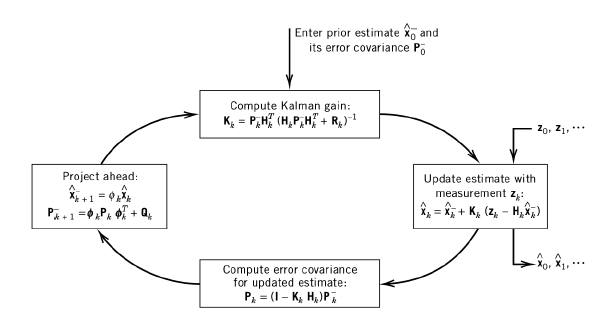


In [8]:
# Implementing Multidimensional Kalman Filter
x = np.zeros((4,len(data)))
for i in range(1,len(data)-1):
  Z = np.array([X_pos[i],
                Y_pos[i],
                X_vel[i],
                Y_vel[i],
                X_gps[i],
                Y_gps[i]])

  # Compute Kalman gain
  K = P@np.transpose(H)@np.linalg.inv(H@P@np.transpose(H)+R)

  # Update estimate with measurement 
  x[:,i] = x[:,i-1] + K@(Z - H@x[:,i-1])

  # Compute error covariance for updated estimate
  P = (np.identity(4) - K@H)@P 

  # Project ahead
  x[:,i+1] = phi@x[:,i]
  P = phi@P@np.transpose(phi)+Q



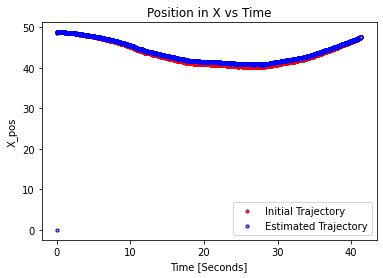

In [9]:
# Data plotting 
plt.scatter(time, X_pos, label="Initial Trajectory", edgecolor='r', s=10) 
plt.scatter(time, x[0,:], label="Estimated Trajectory", edgecolor='b', s=10)
plt.title('Position in X vs Time')
plt.ylabel('X_pos')
plt.xlabel('Time [Seconds]')
plt.legend(loc="best")
plt.show()


## **References:**

[1] https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_orb/py_orb.html

[2] https://stackoverflow.com/questions/30716610/how-to-get-pixel-coordinates-from-feature-matching-in-opencv-python

[3] https://www.geeksforgeeks.org/feature-matching-using-orb-algorithm-in-python-opencv/

[4] https://www.youtube.com/watch?v=zX5NeY-GTO0&t=765s

[5] https://dsp.stackexchange.com/questions/31632/how-do-i-choose-the-parameters-of-a-kalman-filter4

[6] https://mattmaulion.medium.com/color-image-segmentation-image-processing-4a04eca25c0



